In [1]:
import torch
import pennylane as qml

from qulearn.hat_basis import HatBasis
from qulearn.qlayer import (HatBasisQFE,
                            CircuitLayer,
                            MeasurementLayer,
                            MeasurementType)
from qulearn.mps import HatBasisMPS

In [2]:
import torch
import tntorch as tn

def zkron(t1, t2):
    c1 = t1.cores
    c2 = t2.cores
    c3 = [torch.kron(a, b) for a, b in zip(c1, c2)]
    
    t3 = tn.Tensor(c3)
    return t3

def zkron2(tleft, tright):
    # assuming same length of left and right
    coresleft = tleft.cores
    coresright = tright.cores
    coresout = []
    
    for i in range(len(coresleft)):
        coreleft = coresleft[i]
        coreright = coresright[i]
        rankleft1 = coreleft.shape[0]
        rankleft2 = coreleft.shape[-1]
        rankright1 = coreright.shape[0]
        rankright2 = coreright.shape[-1]
        
        site_dim = coreleft.shape[1]
        core = torch.empty((rankleft1*rankright1, site_dim, rankleft2*rankright1))
        for k in range(site_dim):
            core[:, k, :] = torch.kron(coreleft[:, k, :], torch.eye(rankright1))
        coresout.append(core)
         
        site_dim = coreright.shape[1]
        core = torch.empty((rankleft2*rankright1, site_dim, rankleft2*rankright2))
        for k in range(site_dim):
            core[:, k, :] = torch.kron(torch.eye(rankleft2), coreright[:, k, :])
        coresout.append(core)
    
    tout = tn.Tensor(coresout)
    return tout


def kron(t1, t2):
    c1 = t1.cores
    c2 = t2.cores
    c3 = c1 + c2
    t3 = tn.Tensor(c3)
    
    return t3

In [3]:
import tntorch as tn
import numpy as np

t1 = tn.randn([2]*3)
t2 = tn.ones([2]*3)

T1 = t1.numpy().reshape((2**3))
T2 = t2.numpy().reshape((2**3))

t3 = kron(t1, t2)
T3 = t3.numpy().reshape((2**6))

T3_ = np.kron(T1, T2)
delta = abs(T3_ - T3)
delta = np.linalg.norm(delta)
print("delta: ", delta)

t4 = zkron(t1, t2)
t5 = zkron2(t1, t2)
T4 = t4.numpy().reshape((2**6))
T5 = t5.numpy().reshape((2**6))
delta = abs(T4 - T5)
delta = np.linalg.norm(delta)

print(T3)
print("=========")
print(T4)
print("=========")
print(T5)
print("=========")
print("delta: ", delta)

delta:  0.0
[-1.311162  -1.311162  -1.311162  -1.311162  -1.311162  -1.311162
 -1.311162  -1.311162  -0.6058396 -0.6058396 -0.6058396 -0.6058396
 -0.6058396 -0.6058396 -0.6058396 -0.6058396  1.3950641  1.3950641
  1.3950641  1.3950641  1.3950641  1.3950641  1.3950641  1.3950641
  1.5958751  1.5958751  1.5958751  1.5958751  1.5958751  1.5958751
  1.5958751  1.5958751  1.5206887  1.5206887  1.5206887  1.5206887
  1.5206887  1.5206887  1.5206887  1.5206887  0.8525145  0.8525145
  0.8525145  0.8525145  0.8525145  0.8525145  0.8525145  0.8525145
 -1.780365  -1.780365  -1.780365  -1.780365  -1.780365  -1.780365
 -1.780365  -1.780365  -1.7964025 -1.7964025 -1.7964025 -1.7964025
 -1.7964025 -1.7964025 -1.7964025 -1.7964025]
[-1.311162  -1.311162  -0.6058396 -0.6058396 -1.311162  -1.311162
 -0.6058396 -0.6058396  1.3950641  1.3950641  1.5958751  1.5958751
  1.3950641  1.3950641  1.5958751  1.5958751 -1.311162  -1.311162
 -0.6058396 -0.6058396 -1.311162  -1.311162  -0.6058396 -0.6058396
  1.3950

In [4]:
print(t1)
for c in t1.cores:
    print(c.shape[0])

3D TT tensor:

  2   2   2
  |   |   |
 (0) (1) (2)
 / \ / \ / \
1   2   2   1

1
2
2


In [5]:
print(t1.numpy().reshape((2**3)))
print(t2.numpy().reshape((2**3)))
print(T3_)
print(T4)

[-1.311162  -0.6058396  1.3950641  1.5958751  1.5206887  0.8525145
 -1.780365  -1.7964025]
[1. 1. 1. 1. 1. 1. 1. 1.]
[-1.311162  -1.311162  -1.311162  -1.311162  -1.311162  -1.311162
 -1.311162  -1.311162  -0.6058396 -0.6058396 -0.6058396 -0.6058396
 -0.6058396 -0.6058396 -0.6058396 -0.6058396  1.3950641  1.3950641
  1.3950641  1.3950641  1.3950641  1.3950641  1.3950641  1.3950641
  1.5958751  1.5958751  1.5958751  1.5958751  1.5958751  1.5958751
  1.5958751  1.5958751  1.5206887  1.5206887  1.5206887  1.5206887
  1.5206887  1.5206887  1.5206887  1.5206887  0.8525145  0.8525145
  0.8525145  0.8525145  0.8525145  0.8525145  0.8525145  0.8525145
 -1.780365  -1.780365  -1.780365  -1.780365  -1.780365  -1.780365
 -1.780365  -1.780365  -1.7964025 -1.7964025 -1.7964025 -1.7964025
 -1.7964025 -1.7964025 -1.7964025 -1.7964025]
[-1.311162  -1.311162  -0.6058396 -0.6058396 -1.311162  -1.311162
 -0.6058396 -0.6058396  1.3950641  1.3950641  1.5958751  1.5958751
  1.3950641  1.3950641  1.5958751  1

In [6]:
import tntorch
try:
    from typing import TypeAlias
except ImportError:
    from typing_extensions import TypeAlias
MPS: TypeAlias = tntorch.tensor.Tensor
Tensor: TypeAlias = torch.Tensor

class LinearBasis2DMPS:
    def __init__(self, basis: HatBasis, zorder: bool = False) -> None:
        self.basis = basis

        num_qubits = 2*math.log2(basis.num_nodes)
        if not num_qubits.is_integer():
            raise ValueError(
                f"Number of nodes ({basis.num_nodes}) " "must be a power of 2."
            )

        self.num_sites = int(num_qubits)
        self.basis1Dmps = HatBasisMPS(basis)
        self.zorder = zorder
        
    def __call__(self, x: Tensor) -> MPS:
        """
        Constructs the MPS of the hat basis evaluated at a given point x.

        :param x: The input at which to evaluate the hat basis.
        :type x: Tensor
        :returns: The MPS at point x.
        :rtype: MPS
        """

        return self.eval(x)

    def eval(self, x: Tensor) -> MPS:
        """
        Constructs the MPS of the hat basis evaluated at a given point x.

        :param x: The input at which to evaluate the hat basis.
        :type x: Tensor
        :returns: The MPS at point x.
        :rtype: MPS
        """
        
        mpsx = self.basis1Dmps(x[0])
        mpsy = self.basis1Dmps(x[1])
        
        if self.zorder:
            return zkron2(mpsx, mpsy)
        
        return kron(mpsx, mpsy)

In [7]:
import torch
import torch.nn as nn

class SignModelWrapper(nn.Module):
    def __init__(self, old_model):
        super(SignModelWrapper, self).__init__()
        self.old_model = old_model

    def forward(self, x):
        real_value_output = self.old_model(x)
        binary_output = torch.sign(real_value_output)
        return binary_output

In [8]:
from qulearn.qlayer import AltRotCXLayer, HamiltonianLayer, ParallelIQPEncoding, HatBasis, Linear2DBasisQFE
base = 3.0
omega = 1.0
num_qubits = 3
num_nodes = 2**num_qubits
a = -1.0
b = 1.0
hat_basis = HatBasis(a=a, b=b, num_nodes=num_nodes)
var = AltRotCXLayer(wires=2*num_qubits, n_layers=3)

embed = Linear2DBasisQFE(wires=2*num_qubits, basis=hat_basis, sqrt=True, normalize=False, zorder=True)
#embed = ParallelIQPEncoding(wires=2*num_qubits, num_features=2, n_repeat=1, base=base, omega=omega)
obs = qml.PauliZ(5)
model = MeasurementLayer(embed, var, observables=obs, measurement_type=MeasurementType.Expectation)

obs = [qml.PauliZ(j) for j in range(2*num_qubits)]
obs += [qml.PauliX(j) for j in range(2*num_qubits)]
obs += [qml.PauliY(j) for j in range(2*num_qubits)]
model = HamiltonianLayer(embed, var, observables=obs)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([0.99, -0.99])
x = torch.tensor([0., 0.])
print(drawer(x))

0: ──────────────────────────────────────────────────╭U(M3)────────────────Rot(4.91,1.09,3.58)─╭●
1: ─────────────────────────────╭U(M2)───────────────├U(M3)────────────────Rot(2.73,4.48,6.13)─╰X
2: ────────╭U(M1)───────────────├U(M2)───────────────╰U(M3)────────────────Rot(3.17,1.99,1.60)─╭●
3: ─╭U(M0)─├U(M1)───────────────╰U(M2)────────────────Rot(0.43,0.83,1.19)──────────────────────╰X
4: ─├U(M0)─╰U(M1)────────────────Rot(4.29,1.73,5.07)─╭●────────────────────Rot(5.32,1.39,2.23)───
5: ─╰U(M0)──Rot(0.00,4.32,0.06)──────────────────────╰X────────────────────Rot(6.22,1.36,0.70)───

───Rot(3.94,0.79,4.90)─────────────────────────╭●──Rot(3.75,3.22,0.60)─────────────────────────╭●
───Rot(2.58,3.98,1.44)─╭●──Rot(2.02,1.15,0.50)─╰X──Rot(5.37,5.76,3.16)─╭●──Rot(1.18,0.36,3.66)─╰X
───Rot(2.34,4.39,1.63)─╰X──Rot(2.96,0.20,3.27)─╭●──Rot(2.64,3.16,1.71)─╰X──Rot(0.93,1.74,4.27)─╭●
───Rot(5.08,5.68,5.94)─╭●──Rot(4.11,4.48,1.07)─╰X──Rot(2.19,1.50,0.14)─╭●──Rot(5.47,3.24,3.71)─╰X
───────────────────

In [9]:
from qulearn.qkernel import QKernel
import torch

embed_pptn = Linear2DBasisQFE(wires=2*num_qubits, basis=hat_basis, sqrt=True, normalize=False, zorder=True)
embed_angle = ParallelIQPEncoding(wires=2*num_qubits, num_features=2, n_repeat=1, base=base, omega=omega)

ntrain = 10
num_features = 2
X_train = 1.98*torch.rand((ntrain, num_features)) - 0.99
kernel_model = QKernel(embed_pptn, X_train)
kernel_classifier = SignModelWrapper(kernel_model)

scores = kernel_model(X_train)
labels = kernel_classifier(X_train)

print(scores)
print("=========")
print(labels)

tensor([-0.4190,  2.2986, -0.5160,  0.4343, -0.1263,  0.9558,  2.4338,  0.1384,
        -0.4452,  1.4054], grad_fn=<MvBackward0>)
tensor([-1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.],
       grad_fn=<SignBackward0>)


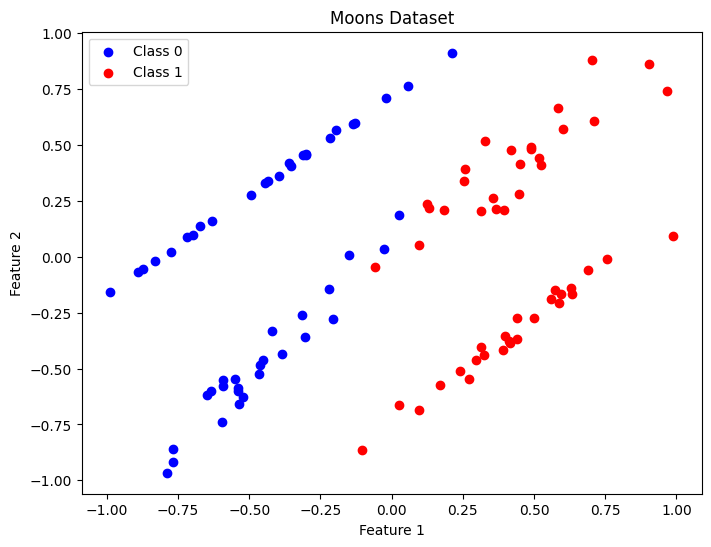

In [10]:
from sklearn.datasets import make_moons, make_classification
import matplotlib.pyplot as plt
X, y = make_moons(n_samples=100, noise=0.2, random_state=42)
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_min = X.min()
X_max = X.max()
X= 1.98 * (X - X_min) / (X_max - X_min) - 0.99

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
plt.title("Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
X_val_tensor = torch.tensor(X_val, dtype=torch.float64)
y_train_tensor = torch.tensor(y_train, dtype=torch.float64)
y_val_tensor = torch.tensor(y_val, dtype=torch.float64)

# Convert y values from {0, 1} to {-1, 1}
y_train_tensor = 2 * y_train_tensor - 1
y_val_tensor = 2 * y_val_tensor - 1

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)


In [12]:
from qulearn.trainer import RidgeRegression
trainer = RidgeRegression(lambda_reg=1.0)

In [13]:
trainer.train(kernel_model, train_dataloader, val_dataloader)

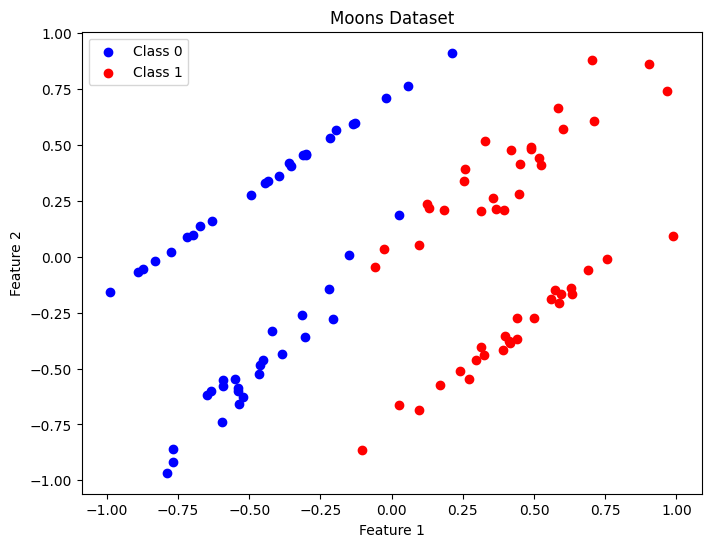

In [14]:
kernel_classifier = SignModelWrapper(kernel_model)

X_tensor = torch.tensor(X, dtype=torch.float64)
y = kernel_classifier(X_tensor)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='blue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
plt.title("Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


In [15]:
model = SignModelWrapper(model)

/Users/mazen.ali/Projects/QuLearn/.venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


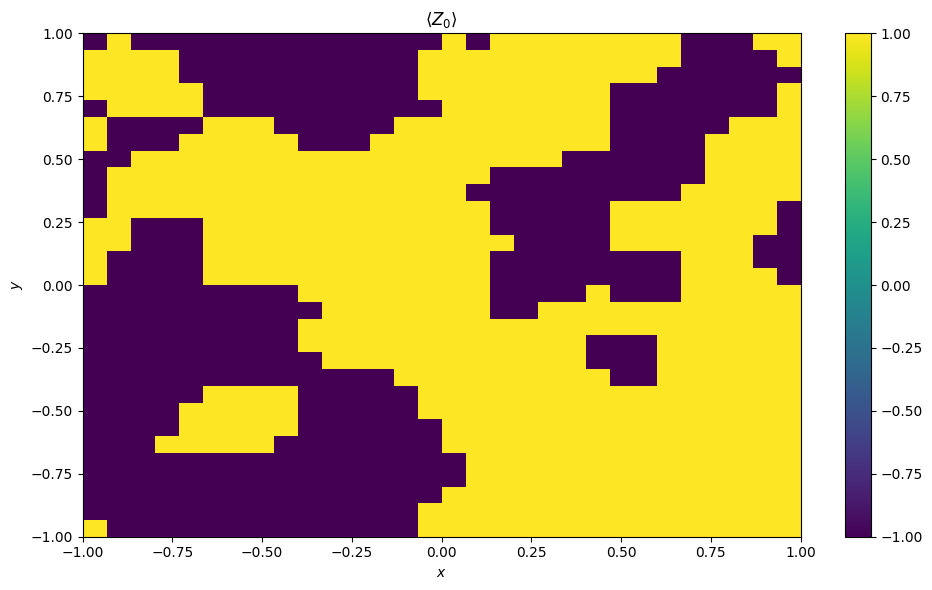

In [16]:
import torch
import matplotlib.pyplot as plt

# Define the number of points in each dimension
num_pnts = 30

# Generate a grid of x and y values
x = torch.linspace(-0.99, 0.99, num_pnts)
y = torch.linspace(-0.99, 0.99, num_pnts)
X, Y = torch.meshgrid(x, y)
Z = torch.empty(num_pnts, num_pnts)

# Evaluate the model at each point in the grid
for i in range(num_pnts):
    for j in range(num_pnts):
        xy = torch.tensor([[X[i, j], Y[i, j]]])
        Z[i, j] = model(xy).item()

# Convert tensors to numpy arrays for plotting
X = X.numpy()
Y = Y.numpy()
Z = Z.numpy()

# Create a 3D surface plot
fig = plt.figure(figsize=(10, 6))
plt.imshow(Z, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis', aspect='auto')

# Add labels and title
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("$\langle Z_0\\rangle$")

# Save the figure
plt.colorbar()
plt.tight_layout()

# Show the plot
plt.show()


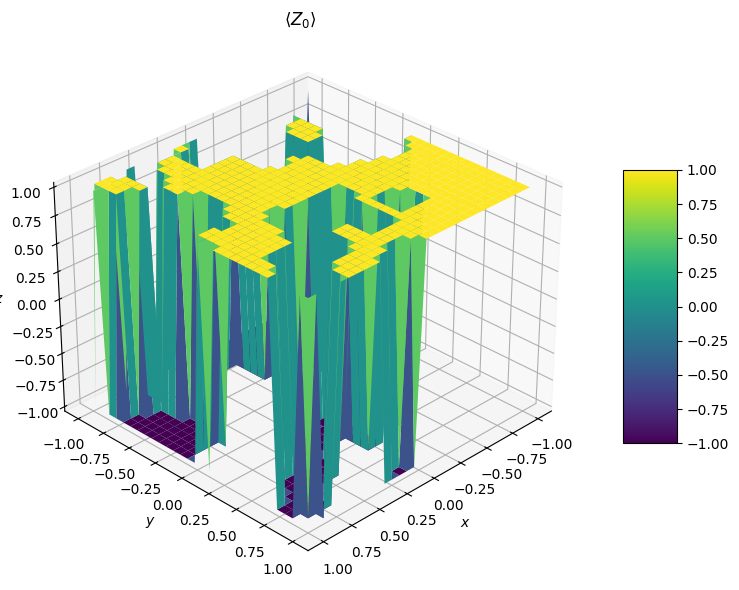

In [17]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Define the number of points in each dimension
num_pnts = 30

# Generate a grid of x and y values
x = torch.linspace(-0.99, 0.99, num_pnts)
y = torch.linspace(-0.99, 0.99, num_pnts)
X, Y = torch.meshgrid(x, y)
Z = torch.empty(num_pnts, num_pnts)

# Evaluate the model at each point in the grid
for i in range(num_pnts):
    for j in range(num_pnts):
        xy = torch.tensor([[X[i, j], Y[i, j]]])
        Z[i, j] = model(xy).item()

# Convert tensors to numpy arrays for plotting
X = X.numpy()
Y = Y.numpy()
Z = Z.numpy()

# Create a 3D surface plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add labels and title
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title("$\langle Z_0\\rangle$")

ax.view_init(elev=30, azim=45)
# Add a color bar which maps values to colors
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Save the figure
plt.tight_layout()

# Show the plot
plt.show()

In [18]:
import numpy as np

num_qubits = 2
num_nodes = 2**num_qubits
a = -1.0
b = 1.0
hat_basis = HatBasis(a=a, b=b, num_nodes=num_nodes)

embed = Linear2DBasisQFE(wires=2*num_qubits, basis=hat_basis, sqrt=True, normalize=False, zorder=False)

dev = qml.device("default.qubit", wires=2*num_qubits)
@qml.qnode(dev)
def circuit(x):
    embed.circuit(x)
    return qml.state()

x = torch.tensor([-0.99, -0.])
out = np.real(circuit(x))
print(out)
print("norm: ", np.linalg.norm(out))

[0.         0.         0.         0.         0.70178351 0.08660251
 0.         0.         0.70178351 0.08660251 0.         0.
 0.         0.         0.         0.        ]
norm:  1.000000093060037


In [19]:
from qulearn.qlayer import HatBasisQFE

embed = HatBasisQFE(wires=2*num_qubits, basis=hat_basis, sqrt=True, normalize=False)

x = torch.tensor([-1.1])
norm = embed.compute_norm(x)
print(norm)
pos = hat_basis.position(x)
a, b = hat_basis.nonz_vals(x)
print(a, b)
print(pos)

0.9219543933868408
tensor([0.1500]) tensor([0.8500])
tensor([-1.])


In [20]:
import torch
import matplotlib.pyplot as plt

num_pnts = 50

# Generate a grid of x and y values
x = torch.linspace(-0.99, 0.99, num_pnts)
y = torch.linspace(-0.99, 0.99, num_pnts)
X, Y = torch.meshgrid(x, y, indexing='xy')
Z = torch.empty(num_pnts, num_pnts)

# Evaluate the circuit at each point in the grid and extract the j-th component
idx = 1
for i in range(num_pnts):
    for k in range(num_pnts):
        xy = torch.tensor([X[i, k], Y[i, k]], dtype=torch.float32)
        out = circuit(xy)[idx]
        Z[i, k] = torch.tensor(out)
# Convert tensors to numpy arrays for plotting
X = X.numpy()
Y = Y.numpy()
Z = Z.numpy()

# Create a 2D heatmap plot
plt.figure(figsize=(10, 6))
plt.imshow(Z, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis', aspect='auto')

# Add labels and title
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f"$\\varphi_j$")

# Add a color bar which maps values to colors
plt.colorbar(label=f'$\\varphi_j$')

# Save the figure
plt.tight_layout()

# Show the plot
plt.show()

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
a = 0.3
b = 0.5

def lambda1(beta1, beta2):
    nom = (b-a)*(beta1-beta2)
    denom = (b-a-1)*beta2-(b-a)*beta1
    
    return nom/denom

def lambda2(beta1, beta2):
    nom = (b-a-1)*(beta1-beta2)
    denom = (b-a-1)*beta2-(b-a)*beta1
    
    return nom/denom

def effbeta(beta1, beta2):
    lam1 = lambda1(beta1, beta2)
    lam2 = lambda2(beta1, beta2)
    
    beta = beta1*(lam1+1)*(1+a-b)+beta2*(b-a)*(lam2+1)
    return beta

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a meshgrid for the range of beta1 and beta2 values
n1 = 50
n2 = 50
beta1_range = np.linspace(0.05, 400, n1)
beta2_range = np.linspace(0.05, 400, n2)
beta1, beta2 = np.meshgrid(beta1_range, beta2_range)

# Compute effbeta for each combination of beta1 and beta2
eff_beta_values = effbeta(beta1, beta2)

# Create a heat plot
plt.figure(figsize=(10, 8))
plt.imshow(eff_beta_values, extent=(0.05, 400, 0.05, 400), origin='lower', aspect='auto')
plt.colorbar(label='effbeta')
plt.xlabel('beta1')
plt.ylabel('beta2')
plt.title('Heat Plot of effbeta')
plt.show()

# Create a surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(beta1, beta2, eff_beta_values, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('beta1')
ax.set_ylabel('beta2')
ax.set_zlabel('effbeta')
ax.set_title('Surface Plot of effbeta')
plt.show()

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, random_split
# Normalize the data to [-1, 1]
beta1_min, beta1_max = beta1.min(), beta1.max()
beta2_min, beta2_max = beta2.min(), beta2.max()
eff_beta_min, eff_beta_max = eff_beta_values.min(), eff_beta_values.max()

beta1_normalized = 2 * (beta1 - beta1_min) / (beta1_max - beta1_min) - 1
beta2_normalized = 2 * (beta2 - beta2_min) / (beta2_max - beta2_min) - 1
eff_beta_normalized = 2 * (eff_beta_values - eff_beta_min) / (eff_beta_max - eff_beta_min) - 1

# Flatten the arrays and combine them
beta1_flat = beta1_normalized.flatten()
beta2_flat = beta2_normalized.flatten()
eff_beta_flat = eff_beta_normalized.flatten()

# Convert to PyTorch tensors
inputs = torch.tensor(np.vstack((beta1_flat, beta2_flat)).T, dtype=torch.float32)
outputs = torch.tensor(eff_beta_flat, dtype=torch.float32).unsqueeze(1)

# Create a dataset and split into training and validation sets
dataset = TensorDataset(inputs, outputs)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Plot the normalized eff_beta values as a heat plot
plt.figure(figsize=(10, 8))
plt.imshow(eff_beta_normalized.reshape(beta1.shape), extent=(-1., 1., -1., 1.), origin='lower', aspect='auto')
plt.colorbar(label='Normalized effbeta')
plt.xlabel('beta1')
plt.ylabel('beta2')
plt.title('Heat Plot of Normalized effbeta')
plt.show()

# Plot the normalized eff_beta values as a surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(beta1_normalized, beta2_normalized, eff_beta_normalized, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('beta1')
ax.set_ylabel('beta2')
ax.set_zlabel('Normalized effbeta')
ax.set_title('Surface Plot of Normalized effbeta')
plt.show()

In [ ]:
from qulearn.qlayer import ParallelIQPEncoding, AltRotCXLayer, HamiltonianLayer
num_features = 2
num_qubits = 6
base = 3.0
omega = 1.0
embed = ParallelIQPEncoding(wires=num_qubits,
                            num_features=num_features,
                            n_repeat=1,
                            base=base,
                            omega=omega)
n_layers = 1
var = AltRotCXLayer(wires=num_qubits, n_layers=n_layers)

obs = [qml.Identity(0), qml.PauliZ(0)]
model = HamiltonianLayer(embed, var, observables=obs)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([1.0, 2.0])
print(drawer(x))
nump = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", nump)

In [ ]:
import torch
import matplotlib.pyplot as plt

# Define the number of points in each dimension
num_pnts = 50

# Generate a grid of x and y values
x = torch.linspace(-0.99, 0.99, num_pnts)
y = torch.linspace(-0.99, 0.99, num_pnts)
X, Y = torch.meshgrid(x, y)
Z = torch.empty(num_pnts, num_pnts)

# Evaluate the model at each point in the grid
for i in range(num_pnts):
    for j in range(num_pnts):
        xy = torch.tensor([X[i, j], Y[i, j]])
        Z[i, j] = model(xy).item()

# Convert tensors to numpy arrays for plotting
X = X.numpy()
Y = Y.numpy()
Z = Z.numpy()

# Create a 3D surface plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add labels and title
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title("$\langle Z_0\\rangle$")

ax.view_init(elev=30, azim=45)
# Add a color bar which maps values to colors
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Save the figure
plt.tight_layout()

# Show the plot
plt.show()